In [6]:
!pip install -q opencv-python numpy pandas matplotlib


In [7]:
import os, time, math, textwrap
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# --------- CONFIG (EDIT IF NEEDED) ----------
TARGET_FPS = 4          # sample 4 frames per second from the video
WINDOW_SECONDS = 3.0    # each analysis window ≈ 3 seconds
STRIDE_SECONDS = 1.5    # slide window every 1.5 seconds

DETAILED_CSV = "trackA_windows_metrics.csv"
SUMMARY_CSV  = "metrics_template.csv"   # 3-column summary file

print("Config loaded.")


Config loaded.


In [8]:
from google.colab import files

print("Upload a short MP4 (10–20 seconds) showing a simple movement (e.g., arm raises).")
uploaded = files.upload()

video_name = list(uploaded.keys())[0]
VIDEO_PATH = "/content/" + video_name
print("Using video:", VIDEO_PATH)


Upload a short MP4 (10–20 seconds) showing a simple movement (e.g., arm raises).


Saving 5319088-uhd_2160_3840_25fps.mp4 to 5319088-uhd_2160_3840_25fps.mp4
Using video: /content/5319088-uhd_2160_3840_25fps.mp4


In [9]:
def load_and_sample_frames(video_path, target_fps=TARGET_FPS):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_s = total_frames / orig_fps

    frame_interval = max(int(round(orig_fps / target_fps)), 1)

    frames = []
    timestamps = []

    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval == 0:
            t = idx / orig_fps
            # keep original BGR for cv2 metrics
            frames.append(frame)
            timestamps.append(t)
        idx += 1

    cap.release()
    print(f"Original FPS: {orig_fps:.2f}, frames: {total_frames}, duration: {duration_s:.2f}s")
    print(f"Sampled {len(frames)} frames at ~{target_fps} FPS.")
    return frames, timestamps, duration_s


def make_windows(frames, timestamps, window_seconds=WINDOW_SECONDS, stride_seconds=STRIDE_SECONDS):
    """
    Group sampled frames into sliding windows by time.
    Returns list of dicts: {window_id, start, end, frames}
    """
    if not frames:
        return []

    windows = []
    start_t = timestamps[0]
    last_t  = timestamps[-1]

    w_id = 0
    t0 = start_t

    while t0 <= last_t:
        t1 = t0 + window_seconds
        w_frames = [f for f, ts in zip(frames, timestamps) if t0 <= ts < t1]
        if len(w_frames) >= 2:
            windows.append({
                "window_id": w_id,
                "start": t0,
                "end": min(t1, last_t),
                "frames": w_frames
            })
            w_id += 1
        t0 += stride_seconds

    print(f"Created {len(windows)} windows.")
    return windows

frames, ts, vid_duration = load_and_sample_frames(VIDEO_PATH)
windows = make_windows(frames, ts)


Original FPS: 25.00, frames: 562, duration: 22.48s
Sampled 94 frames at ~4 FPS.
Created 15 windows.


In [10]:
class ReliVideoHeuristicModel:
    """
    Lightweight 'video model' for Track A:
    - motion intensity (optical difference)
    - tremor index          (derived from motion)
    - symmetry score        (left vs right brightness)
    plus a human-readable summary string.
    """

    def __init__(self):
        pass

    def _metrics(self, frames):
        import cv2

        if len(frames) < 2:
            return {"motion": 0.0, "tremor": 0.0, "symmetry": 1.0}

        # Downsample for speed
        small = [cv2.resize(f, (160, 120)) for f in frames]
        gray  = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in small]

        diffs = []
        asym  = []

        for i in range(1, len(gray)):
            d = cv2.absdiff(gray[i], gray[i-1])
            diffs.append(d.mean())

            h, w = gray[i].shape
            left  = gray[i][:, :w//2].mean()
            right = gray[i][:, w//2:].mean()
            asym.append(abs(left - right))

        motion = float(np.mean(diffs)) if diffs else 0.0
        # Normalize tremor to 0..1-ish range
        tremor = float(np.clip(motion / 25.0, 0.0, 1.0))
        # Symmetry: 1 = perfect balance, 0 = highly asymmetric
        symmetry = float(np.clip(1.0 - (np.mean(asym) / 50.0), 0.0, 1.0)) if asym else 1.0

        return {"motion": motion, "tremor": tremor, "symmetry": symmetry}

    def infer(self, frames, window_seconds):
        t0 = time.time()
        m = self._metrics(frames)
        latency_s = time.time() - t0

        motion  = m["motion"]
        tremor  = m["tremor"]
        sym     = m["symmetry"]

        # Qualitative movement descriptors
        if motion < 5:
            mov_desc = "very low movement"
        elif motion < 15:
            mov_desc = "moderate movement"
        else:
            mov_desc = "high-intensity movement"

        if tremor < 0.15:
            trem_desc = "no visible tremor"
        elif tremor < 0.4:
            trem_desc = "mild tremor"
        elif tremor < 0.7:
            trem_desc = "moderate tremor"
        else:
            trem_desc = "strong tremor"

        if sym > 0.85:
            sym_desc = "well-balanced between left and right"
        elif sym > 0.6:
            sym_desc = "slightly asymmetric"
        else:
            sym_desc = "clearly asymmetric between sides"

        summary = textwrap.dedent(f"""
            Movement: {mov_desc} (motion_score={motion:.2f}).
            Tremor: {trem_desc} (tremor_index={tremor:.2f}).
            Symmetry: {sym_desc} (symmetry_score={sym:.2f}).
            Overall, this time window shows {mov_desc} with {trem_desc} and {sym_desc}.
        """).strip()

        return m, summary, latency_s

model = ReliVideoHeuristicModel()
print("Heuristic video model ready.")


Heuristic video model ready.


In [11]:
records = []

for w in windows:
    w_id   = w["window_id"]
    start  = w["start"]
    end    = w["end"]
    w_frames = w["frames"]
    window_secs = end - start

    # Inference (movement/tremor/symmetry) + latency
    metrics, summary, latency_s = model.infer(w_frames, window_secs)

    latency_ms = latency_s * 1000.0
    rtf = window_secs / latency_s if latency_s > 0 else float("inf")

    rec = {
        "window_id": w_id,
        "start_sec": start,
        "end_sec": end,
        "window_duration_s": window_secs,
        "num_frames": len(w_frames),
        "latency_ms": latency_ms,
        "rtf": rtf,
        "motion_score": metrics["motion"],
        "tremor_index": metrics["tremor"],
        "symmetry_score": metrics["symmetry"],
        "summary": summary,
    }
    records.append(rec)

    # Print console log for qualitative reasoning
    print("\n" + "="*60)
    print(f"Window {w_id}  ({start:.2f}–{end:.2f} s, {len(w_frames)} frames)")
    print(f"Latency: {latency_ms:.2f} ms   |   RTF: {rtf:.4f}")
    print(summary)
    print("="*60)

df = pd.DataFrame(records).sort_values("window_id").reset_index(drop=True)
df



Window 0  (0.00–3.00 s, 13 frames)
Latency: 25.67 ms   |   RTF: 116.8764
Movement: moderate movement (motion_score=6.89).
Tremor: mild tremor (tremor_index=0.28).
Symmetry: well-balanced between left and right (symmetry_score=0.96).
Overall, this time window shows moderate movement with mild tremor and well-balanced between left and right.

Window 1  (1.50–4.50 s, 12 frames)
Latency: 3.05 ms   |   RTF: 982.7329
Movement: moderate movement (motion_score=6.80).
Tremor: mild tremor (tremor_index=0.27).
Symmetry: well-balanced between left and right (symmetry_score=0.96).
Overall, this time window shows moderate movement with mild tremor and well-balanced between left and right.

Window 2  (3.00–6.00 s, 12 frames)
Latency: 3.00 ms   |   RTF: 1001.1865
Movement: moderate movement (motion_score=6.39).
Tremor: mild tremor (tremor_index=0.26).
Symmetry: well-balanced between left and right (symmetry_score=0.96).
Overall, this time window shows moderate movement with mild tremor and well-balan

,window_id,start_sec,end_sec,window_duration_s,num_frames,latency_ms,rtf,motion_score,tremor_index,symmetry_score,summary
0,0,0.0,3.00,3.00,13,25.668144,116.876389,6.890265,0.275611,0.960139,Movement: moderate movement (motion_score=6.89...
1,1,1.5,4.50,3.00,12,3.052711,982.732896,6.799290,0.271972,0.958819,Movement: moderate movement (motion_score=6.80...
2,2,3.0,6.00,3.00,12,2.996445,1001.186505,6.390464,0.255619,0.964526,Movement: moderate movement (motion_score=6.39...
3,3,4.5,7.50,3.00,13,3.218889,931.998519,6.572964,0.262919,0.975310,Movement: moderate movement (motion_score=6.57...
4,4,6.0,9.00,3.00,13,3.185749,941.693758,7.129158,0.285166,0.950630,Movement: moderate movement (motion_score=7.13...
5,5,7.5,10.50,3.00,12,2.937794,1021.174485,6.884356,0.275374,0.953759,Movement: moderate movement (motion_score=6.88...
6,6,9.0,12.00,3.00,12,2.998590,1000.470064,7.346373,0.293855,0.975596,Movement: moderate movement (motion_score=7.35...
7,7,10.5,13.50,3.00,13,3.202915,936.646717,7.062227,0.282489,0.940832,Movement: moderate movement (motion_score=7.06...
8,8,12.0,15.00,3.00,13,3.186941,941.341513,6.333247,0.253330,0.948246,Movement: moderate movement (motion_score=6.33...
9,9,13.5,16.50,3.00,12,2.928972,1024.250061,6.041937,0.241677,0.980181,Movement: moderate movement (motion_score=6.04...


In [12]:
# 1) Detailed per-window metrics
df.to_csv(DETAILED_CSV, index=False)
print("Saved detailed per-window metrics to:", DETAILED_CSV)

# 2) Simple summary metrics (3 columns: metric, value, notes)
avg_latency_ms = df["latency_ms"].mean() if not df.empty else float("nan")
avg_rtf        = df["rtf"].mean()        if not df.empty else float("nan")
avg_motion     = df["motion_score"].mean() if not df.empty else float("nan")
avg_tremor     = df["tremor_index"].mean() if not df.empty else float("nan")
avg_symmetry   = df["symmetry_score"].mean() if not df.empty else float("nan")

summary_rows = [
    {"metric": "trackA_avg_latency_ms", "value": f"{avg_latency_ms:.2f}", "notes": "Average per-window inference latency"},
    {"metric": "trackA_avg_rtf",        "value": f"{avg_rtf:.4f}",        "notes": "Real-time factor (window_duration / latency)"},
    {"metric": "trackA_avg_motion",     "value": f"{avg_motion:.2f}",     "notes": "Average motion intensity across windows"},
    {"metric": "trackA_avg_tremor",     "value": f"{avg_tremor:.3f}",     "notes": "Average tremor index (0–1)"},
    {"metric": "trackA_avg_symmetry",   "value": f"{avg_symmetry:.3f}",   "notes": "Average symmetry score (0–1)"},
]

summary_df = pd.DataFrame(summary_rows, columns=["metric", "value", "notes"])
summary_df.to_csv(SUMMARY_CSV, index=False)
print("Saved summary metrics to:", SUMMARY_CSV)
summary_df


Saved detailed per-window metrics to: trackA_windows_metrics.csv
Saved summary metrics to: metrics_template.csv


,metric,value,notes
0,trackA_avg_latency_ms,4.48,Average per-window inference latency
1,trackA_avg_rtf,909.6076,Real-time factor (window_duration / latency)
2,trackA_avg_motion,6.90,Average motion intensity across windows
3,trackA_avg_tremor,0.276,Average tremor index (0–1)
4,trackA_avg_symmetry,0.964,Average symmetry score (0–1)


In [13]:
pd.read_csv("metrics_template.csv")


,metric,value,notes
0,trackA_avg_latency_ms,4.4800,Average per-window inference latency
1,trackA_avg_rtf,909.6076,Real-time factor (window_duration / latency)
2,trackA_avg_motion,6.9000,Average motion intensity across windows
3,trackA_avg_tremor,0.2760,Average tremor index (0–1)
4,trackA_avg_symmetry,0.9640,Average symmetry score (0–1)


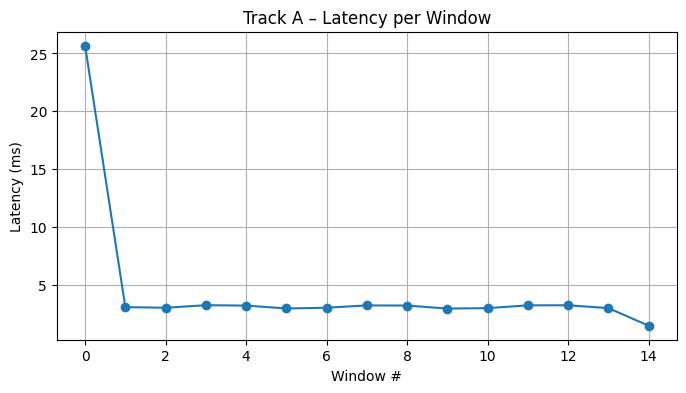

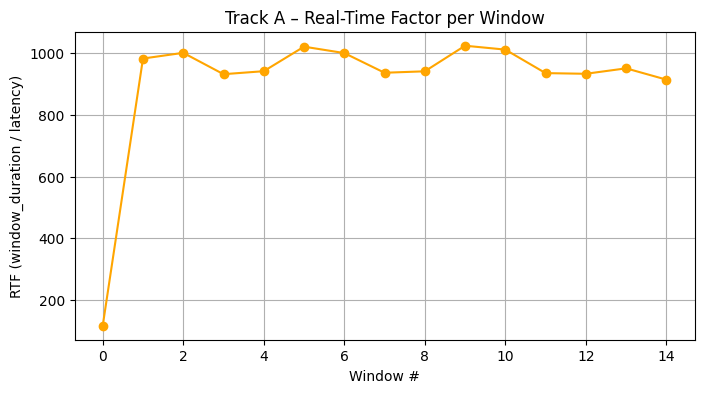

In [14]:
if not df.empty:
    # Latency plot
    plt.figure()
    plt.plot(df["window_id"], df["latency_ms"], marker="o")
    plt.title("Track A – Latency per Window")
    plt.xlabel("Window #")
    plt.ylabel("Latency (ms)")
    plt.show()

    # RTF plot
    plt.figure()
    plt.plot(df["window_id"], df["rtf"], marker="o", color="orange")
    plt.title("Track A – Real-Time Factor per Window")
    plt.xlabel("Window #")
    plt.ylabel("RTF (window_duration / latency)")
    plt.show()
